In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model


In [32]:
# Read the historical match data
df=pd.read_csv('../data/results.csv')
df=df.sort_index()
df.index=pd.to_datetime(df['date'])
df=df[df.index>'1945-01-01']
df.sort_index()
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,,
1945-01-06,1945-01-06,Argentina,Paraguay,5.0,2.0,Copa Chevallier Boutell,Buenos Aires,Argentina,False
1945-01-09,1945-01-09,Argentina,Paraguay,5.0,3.0,Copa Chevallier Boutell,Buenos Aires,Argentina,False
1945-01-14,1945-01-14,Chile,Ecuador,6.0,3.0,Copa América,Santiago,Chile,False
1945-01-18,1945-01-18,Argentina,Bolivia,4.0,0.0,Copa América,Santiago,Chile,True
1945-01-21,1945-01-21,Brazil,Colombia,3.0,0.0,Copa América,Santiago,Chile,True


In [33]:
# A simplified version of the FIFA world ranking model:
# https://digitalhub.fifa.com/m/f99da4f73212220/original/edbm045h0udbwkqew35a-pdf.pdf

# Predicts the expected result: P(A) winning
# Based on the elo chess ranking system

# list of conf tournaments for weighting
confederation_tournaments=['AFC Asian Cup','African Cup of Nations','UEFA Euro','Copa América','CONCACAF Championship',
                           'Oceania Nations Cup']

# FIFA rankings weigh elo point exchanges by tournament
def k_value(tournament):
  k=5
  if tournament == 'Friendly':
      k=10
  elif tournament == 'FIFA World Cup qualification':
      k=25
  elif tournament in confederation_tournaments:
      k=40
  elif tournament == 'FIFA World Cup':
      k=55
  return k

# Calculate exp result
def expected_result(loc,aw):
  dr=loc-aw
  we=(1/(10**(-dr/600)+1))
  return [np.round(we,3),1-np.round(we,3)]

# Extract actual result
def actual_result(loc,aw):
  if loc<aw:
      wa=1
      wl=0
  elif loc>aw:
      wa=0
      wl=1
  elif loc==aw:
      wa=0.5
      wl=0.5
  return [wl,wa]

# Calculate elo point exchange
def calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament):
  k=k_value(tournament)
  wl,wv=actual_result(local_goals,away_goals)
  wel,wev=expected_result(elo_l,elo_v)
  
  elo_ln=elo_l+k*(wl-wel)
  elo_vn=elo_v+k*(wv-wev)
  
  return elo_ln,elo_vn
  

In [34]:
# Calculate ELO after each match in the archive
current_elo={}
for idx,row in df.iterrows():
    try:
        # print(row['date'])
        # Getting the data that it is nedeed to calculate the elo 
        local=row['home_team']
        away=row['away_team']
        local_goals=row['home_score']
        away_goals=row['away_score']
        tournament = row['tournament']
        
        # Getting elo before match. If it is the first match played, the elo is initialized to 1500.
        if local not in current_elo.keys():
            current_elo[local]=1500
        
        if away not in current_elo.keys():
            current_elo[away]=1500
        
        #calculating and updating elo
        elo_l=current_elo[local]
        elo_v=current_elo[away]
        elo_ln,elo_vn=calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament)

        current_elo[local]=elo_ln
        current_elo[away]=elo_vn
        
        #Saving results in dataframe
        df.loc[idx,'Elo_h_after']=elo_ln
        df.loc[idx,'Elo_a_after']=elo_vn 
        df.loc[idx,'Elo_h_before']=elo_l
        df.loc[idx,'Elo_a_before']=elo_v
    except Exception as e:
        print(e)

local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' 

<AxesSubplot:xlabel='date'>

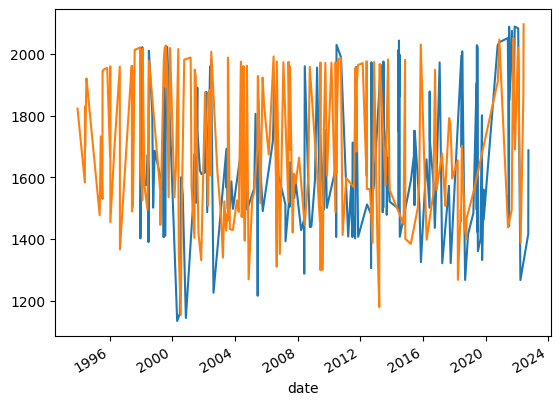

In [35]:
# Lets check Brazil's ELO for home and away games - they should be very similar
df[ ( df['home_team']=='Brazil' )]['Elo_h_after'].dropna().tail(200).plot()
df[ ( df['away_team']=='Brazil' )]['Elo_a_after'].dropna().tail(200).plot()

In [36]:
# Tidy up some country names
df['home_team'] = df['home_team'].replace(['United States'], 'USA')
df['away_team'] = df['away_team'].replace(['United States'], 'USA')
df['home_team'] = df['home_team'].replace(['South Korea'], 'Korea Republic')
df['away_team'] = df['away_team'].replace(['South Korea'], 'Korea Republic')


In [37]:
# Get the world cup fixtures
world_cup_schedule=pd.read_csv('../data/fifa-world-cup-2022-UTC.csv')

# Extract the teams 
wc_teams=pd.unique(world_cup_schedule[['Home Team','Away Team']].values.ravel()).tolist()

# remove TBC match data
drop_list=['1A', '2B', '1C', '2D', '1D', '2C',
       '1B', '2A', '1E', '2F', '1G', '2H', '1F', '2E', '1H', '2G',
       'To be announced']

wc_teams=list(set(wc_teams) - set(drop_list))

In [38]:
# Build the rankings of the WC teams, combining their elo updates from home and away matches since 2012
def build_rankings():
    data={}
    for t in wc_teams:
        data[t]=pd.concat([df[ ( df['away_team']==t )]['Elo_a_after'],
        df[ ( df['home_team']==t )]['Elo_h_after']]).resample('1D').mean().loc['2012-01-01':'2022-11-01'].dropna()
    rankings=pd.DataFrame(data)
    rankings=rankings.interpolate(method='ffill')
    return rankings

In [39]:
rankings=build_rankings()

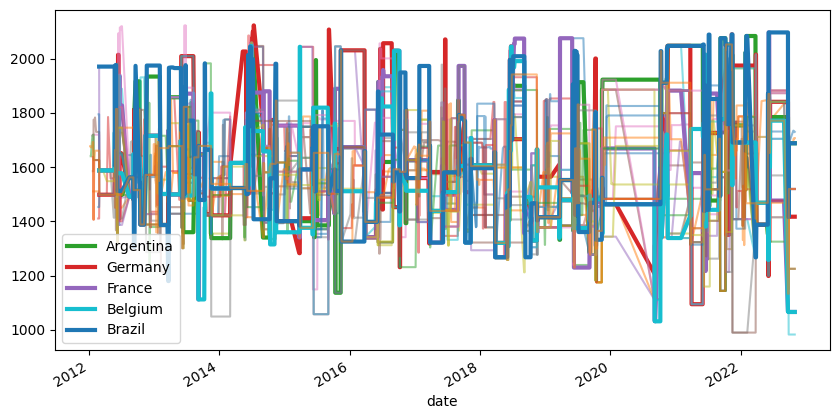

In [40]:
# Plot the ratings of the WC teams with a few favourites in bold
to_plot=['Brazil','Germany','Argentina','France','Belgium']

plt.figure(figsize=(10,5))
for t in wc_teams:
    if t in to_plot:
        rankings[t].plot(lw=3,label=t)
    else:
        rankings[t].plot(label='_',alpha=0.5)
plt.legend()

In [16]:
# Extract some feature data from the match and elo archive
feature_data={}

for t in wc_teams:
    print('Processing '+t)
    team_elo=[]
    opp_elo=[]
    gs=[]
    gc=[]
    result=[]
    for idx,row in df[df.index>'2014-01-01'].iterrows():

        # for home games
        if row['home_team']==t:
            team_elo.append(row['Elo_h_before'])
            opp_elo.append(row['Elo_a_before'])
            gs.append(row['home_score'])
            gc.append(row['away_score'])
            if row['home_score']>row['away_score']:
                result.append(1)
            elif row['home_score']<row['away_score']:
                result.append(0)
            else:
                result.append(0.5)
        
        # for away games
        elif row['away_team']==t:
            team_elo.append(row['Elo_a_before'])
            opp_elo.append(row['Elo_h_before'])
            gs.append(row['away_score'])
            gc.append(row['home_score'])
            if row['away_score']>row['home_score']:
                result.append(1)
            elif row['away_score']<row['home_score']:
                result.append(0)
            else:
                result.append(0.5)

    feature_data[t]=pd.DataFrame({
        'team_elo':team_elo,
        'opp_elo':opp_elo,
        'gs':gs,
        'gc':gc,
        'result':result
    }).dropna()



Processing Saudi Arabia
Processing Mexico
Processing Australia
Processing Iran
Processing Serbia
Processing Ghana
Processing USA
Processing Poland
Processing Denmark
Processing Portugal
Processing Japan
Processing Wales
Processing Argentina
Processing Germany
Processing France
Processing Switzerland
Processing Spain
Processing Cameroon
Processing Canada
Processing England
Processing Korea Republic
Processing Qatar
Processing Senegal
Processing Morocco
Processing Croatia
Processing Ecuador
Processing Uruguay
Processing Netherlands
Processing Costa Rica
Processing Belgium
Processing Brazil
Processing Tunisia


In [17]:
# Check an example of feature data
feature_data['Brazil']

,team_elo,opp_elo,gs,gc,result
0,1992.325,1645.475,5.0,0.0,1.0
1,1994.415,1547.680,4.0,0.0,1.0
2,1995.945,1672.410,1.0,0.0,1.0
3,1998.185,1808.520,3.0,1.0,1.0
4,2016.115,1762.840,0.0,0.0,0.5
...,...,...,...,...,...
103,2091.355,1447.960,4.0,0.0,1.0
104,2093.305,1837.525,5.0,1.0,1.0
105,2096.035,1868.365,1.0,0.0,1.0
106,2098.975,1654.180,3.0,0.0,1.0


In [18]:
# Extract the input features for all teams into a single array (for fitting the scaler)
all_X=[]
for t in wc_teams:
    all_X.append(feature_data[t][['team_elo','opp_elo']])
all_X=np.concatenate(all_X)

In [19]:
# Setup the scaler
scaler = MinMaxScaler()
scaler.fit(all_X)

gs_models={}
gc_models={}

# For each team build two models,
#   - one that predicts goals scored based on home and away elo
#   - one that predicts goals conceded based on home and away elo
for t in wc_teams:
    print('Processing '+t+' ('+str(len(feature_data[t]))+' matches)')

    X=feature_data[t][['team_elo','opp_elo']].values
    y_gs=feature_data[t]['gs'].values
    y_gc=feature_data[t]['gc'].values

    X=scaler.transform(X)
    model_gs = linear_model.Ridge(alpha=.5)
    model_gs.fit(X, y_gs)
    gs_models[t]=model_gs

    model_gc = linear_model.Ridge(alpha=.5)
    model_gc.fit(X, y_gc)
    gc_models[t]=model_gc




Processing Saudi Arabia (110 matches)
Processing Mexico (145 matches)
Processing Australia (87 matches)
Processing Iran (95 matches)
Processing Serbia (89 matches)
Processing Ghana (99 matches)
Processing USA (126 matches)
Processing Poland (95 matches)
Processing Denmark (97 matches)
Processing Portugal (111 matches)
Processing Japan (115 matches)
Processing Wales (86 matches)
Processing Argentina (107 matches)
Processing Germany (113 matches)
Processing France (114 matches)
Processing Switzerland (99 matches)
Processing Spain (104 matches)
Processing Cameroon (109 matches)
Processing Canada (73 matches)
Processing England (109 matches)
Processing Korea Republic (120 matches)
Processing Qatar (132 matches)
Processing Senegal (103 matches)
Processing Morocco (111 matches)
Processing Croatia (105 matches)
Processing Ecuador (89 matches)
Processing Uruguay (95 matches)
Processing Netherlands (100 matches)
Processing Costa Rica (114 matches)
Processing Belgium (108 matches)
Processing Bra

In [25]:
# Function to take given team names and simulate the result
def model_game_goals(team_a, team_b):

    team_a_elo=rankings[team_a].iloc[-1]
    team_b_elo=rankings[team_b].iloc[-1]
    
    team_a_goals_scored=gs_models[team_a].predict(scaler.transform(np.array([team_a_elo,team_b_elo]).reshape(1,-1)))
    team_b_goals_conceded=gc_models[team_b].predict(scaler.transform(np.array([team_b_elo,team_a_elo]).reshape(1,-1)))
    team_a_ave_goals=np.round((team_a_goals_scored+team_b_goals_conceded)/2,0)

    team_b_goals_scored=gs_models[team_b].predict(scaler.transform(np.array([team_b_elo,team_a_elo]).reshape(1,-1)))
    team_a_goals_conceded=gc_models[team_a].predict(scaler.transform(np.array([team_a_elo,team_b_elo]).reshape(1,-1)))
    team_b_ave_goals=np.round((team_b_goals_scored+team_a_goals_conceded)/2,0)

    # return team_a_ave_goals, team_b_ave_goals, team_a_elo, team_b_elo
    # return team_a_goals_scored, team_b_goals_scored, team_a_goals_conceded, team_b_goals_conceded, team_a_elo, team_b_elo

    # return team_b_goals_conceded, team_a_goals_conceded, team_a_elo, team_b_elo

    return team_a_goals_scored, team_b_goals_scored, team_a_elo, team_b_elo
    

In [26]:
# Test with the opening game (home goals, away goals, home elo, away elo)
model_game_goals('Qatar', 'Ecuador')

(array([1.27789879]),
 array([1.39600158]),
 1707.5499999999984,
 1705.3099999999977)

In [27]:
# Let's predict each game
for idx, row in world_cup_schedule.iterrows():
    try:
        result=model_game_goals(row['Home Team'],row['Away Team'])
        print(row['Home Team']+' ('+str(int(result[2]))+')   '+str(int(result[0]))+'  -  '+str(int(result[1]))+'   '+row['Away Team']+' ('+str(int(result[3]))+')')
    except:
        pass


Qatar (1707)   1  -  1   Ecuador (1705)
England (1961)   1  -  0   Iran (1886)
Senegal (1791)   0  -  1   Netherlands (1977)
USA (1782)   1  -  1   Wales (1689)
Argentina (2033)   1  -  0   Saudi Arabia (1730)
Denmark (1835)   2  -  1   Tunisia (1648)
Mexico (1834)   1  -  1   Poland (1725)
France (2050)   1  -  0   Australia (1777)
Morocco (1768)   1  -  1   Croatia (1858)
Germany (1973)   1  -  0   Japan (1864)
Spain (2016)   2  -  0   Costa Rica (1717)
Belgium (2021)   2  -  0   Canada (1670)
Switzerland (1833)   1  -  0   Cameroon (1722)
Uruguay (1873)   1  -  0   Korea Republic (1844)
Portugal (1908)   2  -  0   Ghana (1654)
Brazil (2102)   2  -  0   Serbia (1751)
Wales (1689)   0  -  1   Iran (1886)
Qatar (1707)   1  -  1   Senegal (1791)
Netherlands (1977)   2  -  0   Ecuador (1705)
England (1961)   1  -  0   USA (1782)
Tunisia (1648)   1  -  1   Australia (1777)
Poland (1725)   1  -  0   Saudi Arabia (1730)
France (2050)   1  -  0   Denmark (1835)
Argentina (2033)   1  -  0   M

In [30]:
# Let's do the same but not round the goal values
for idx, row in world_cup_schedule.iterrows():
    try:
        result=model_game_goals(row['Home Team'],row['Away Team'])
        print(row['Home Team']+' ('+str(np.round(result[2],2))+')   '+str(np.round(result[0],2))+'  -  '+str(np.round(result[1],2))+'   '+row['Away Team']+' ('+str(np.round(result[3],2))+')')
    except:
        pass


Qatar (1707.55)   [1.28]  -  [1.4]   Ecuador (1705.31)
England (1961.25)   [1.33]  -  [-0.4]   Iran (1886.93)
Senegal (1791.48)   [0.73]  -  [1.96]   Netherlands (1977.23)
USA (1782.77)   [1.68]  -  [1.03]   Wales (1689.81)
Argentina (2033.96)   [1.9]  -  [-0.39]   Saudi Arabia (1730.7)
Denmark (1835.66)   [2.]  -  [1.01]   Tunisia (1648.99)
Mexico (1834.51)   [1.47]  -  [1.2]   Poland (1725.63)
France (2050.26)   [1.91]  -  [0.19]   Australia (1777.84)
Morocco (1768.69)   [1.24]  -  [1.54]   Croatia (1858.01)
Germany (1973.61)   [1.77]  -  [0.6]   Japan (1864.84)
Spain (2016.65)   [2.18]  -  [0.65]   Costa Rica (1717.61)
Belgium (2021.11)   [2.65]  -  [-0.38]   Canada (1670.1)
Switzerland (1833.55)   [1.72]  -  [0.85]   Cameroon (1722.71)
Uruguay (1873.15)   [1.23]  -  [0.96]   Korea Republic (1844.24)
Portugal (1908.88)   [2.1]  -  [0.69]   Ghana (1654.78)
Brazil (2102.02)   [2.08]  -  [0.75]   Serbia (1751.02)
Wales (1689.81)   [0.88]  -  [1.32]   Iran (1886.93)
Qatar (1707.55)   [1

In [29]:
# Let's check the pre-tournament rankings
rankings.tail(1).max().sort_values(ascending=False)

Brazil            2102.025
France            2050.260
Argentina         2033.960
Belgium           2021.110
Spain             2016.650
Netherlands       1977.225
Germany           1973.615
England           1961.255
Portugal          1908.875
Iran              1886.930
Uruguay           1873.145
Japan             1864.840
Croatia           1858.010
Korea Republic    1844.235
Denmark           1835.665
Mexico            1834.515
Switzerland       1833.545
Senegal           1791.480
USA               1782.770
Australia         1777.835
Morocco           1768.685
Serbia            1751.015
Saudi Arabia      1730.700
Poland            1725.630
Cameroon          1722.710
Costa Rica        1717.610
Qatar             1707.550
Ecuador           1705.310
Wales             1689.810
Canada            1670.105
Ghana             1654.780
Tunisia           1648.990
dtype: float64